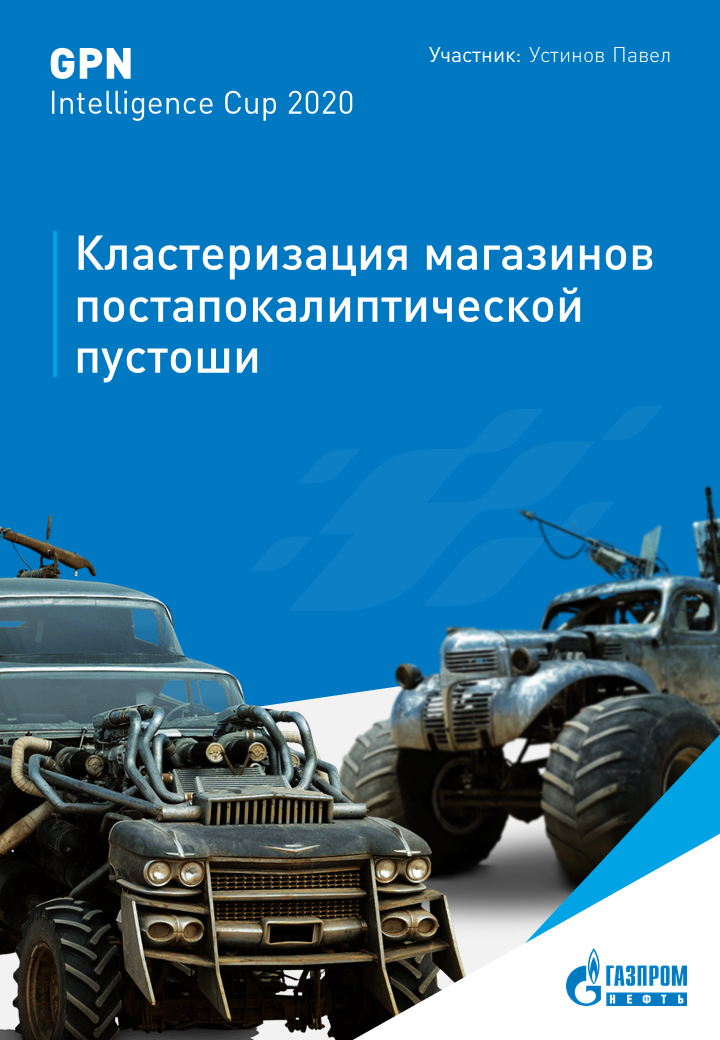

In [1]:
import numpy as np
import pandas as pd
import warnings

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

warnings.filterwarnings('ignore')

# Задача
---
Для лучшего управления магазинами, в частности, для более оптимального планирования промо-кампаний и прогнозирования спроса, вам необходимо разбить магазины на кластеры похожих. Единственный способ, которым пользовалась компания в прошлом – это разбитие по географическому признаку, то есть по городам. Но вы верите, что прочие характеристики магазинов, а самое главное, профили продаж магазинов, помогут сделать это гораздо точнее.

Вы должны изучить данные, выбрать метрику качества кластеризации, придумать и посчитать информативные признаки (например, доля продаж «патронов» по пятницам) и построить наиболее качественный алгоритм кластеризации.

Дополнительным плюсом будет, если вы сможете обосновать, насколько построенная кластеризация лучше, чем разбитие просто по городам.

# Предупреждение
---
Так как некоторые фрагменты кода выполняются довольно долго, результаты этих операций записывались в отдельные csv-файлы (все они есть в архиве), чтобы при необходимости совершить подгрузку без перезапуска данного фрагмента. Такие фрагменты были вынесены в **отдельные подразделы, ограниченные с двух сторон клетками:**

### *START of time-consuming fragment*

In [ ]:
# Some time-consuming code

### *END of time-consuming fragment*

Такие подразделы **могут быть пропущены**, если нет желания тратить время на их выполнение. Сразу же в следующей клетке из csv-файла будут подгружены результаты, и целостность кода нарушена не будет.

# Импорт данных
---

In [557]:
cities = pd.read_parquet('cities.parquet')
sales = pd.read_parquet('sales.parquet')
shops = pd.read_parquet('shops.parquet')

### Данные о разбивке городов по локациям

In [4]:
cities

,city,location
0,Крепость Джита,Скалистый Могильник
1,Суховей,Скалистый Могильник
2,Храм Фритюра,Скалистый Могильник
3,Убежище Жестянщика,Свистящие Степи
4,Газтаун,Радиоактивная Пустошь
5,Пасть,Свистящие Степи
6,Аэропорт,Скалистый Могильник
7,Равнина Маяка,Радиоактивная Пустошь
8,Дизельные Жилы,Свистящие Степи
9,Темница,Радиоактивная Пустошь


### Данные по продажам

- **shop_id** – уникальный идентификатор магазина
- **owner** – владелец магазина
- **number_of_counters** – количество работающих прилавков/продавцов
- **goods_type** – тип товара
- **total_items_sold** – суммарные продажи в этот день в этом магазине в штуках

In [8]:
sales.head()

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0
1,2146-01-01,0,Рейдеры,4,Хлам,26.0
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0
3,2146-01-01,1,Рейдеры,5,Съедобный хлам,17.0
4,2146-01-01,1,Рейдеры,5,Хлам,9.0


### Данные по характеристикам магазинов

- **neighborhood** – в какой окрестности находится магазин
- **city** – в каком городе находится магазин
- **year_opened** – в каком году открыт магазин
- **is_on_the_road** – находится ли магазин прямо у дороги
- **is_with_the_well** – есть ли у магазина колодец
- **is_with_additional_services** – есть ли в магазине дополнительные сервисы
- **shop_type** – тип магазина

Данный источник является менее точным, чем данные о продажах, так как ведётся и обновляется вручную.

In [10]:
shops.head()

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,2109,нет,да,да,1
1,601,В центре,Суховей,2137,нет,нет,нет,4
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,None
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2


Зададим простую функцию для сбора базовой статистики

In [556]:
def simple_stats(df):
    df_stats = pd.concat([df.dtypes, df.count(), df.nunique(), df.isna().sum()], axis=1)
    df_stats.columns = ['dtype', 'count', 'unique', 'na_values']
    return df_stats

Выполним проверку для наших таблиц

In [46]:
simple_stats(cities)

,dtype,count,unique,na_values
city,object,15,15,0
location,object,15,3,0


In [47]:
simple_stats(sales)

,dtype,count,unique,na_values
date,datetime64[ns],5081459,730,0
shop_id,int64,5081459,845,0
owner,object,5081459,5,0
number_of_counters,int32,5081459,23,0
goods_type,object,5081459,11,0
total_items_sold,float64,5081459,65467,0


In [558]:
simple_stats(shops)

,dtype,count,unique,na_values
shop_id,int32,845,845,0
neighborhood,object,845,7,0
city,object,788,15,57
year_opened,int32,845,56,0
is_on_the_road,object,838,2,7
is_with_the_well,object,785,2,60
is_with_additional_services,object,784,2,61
shop_type,object,713,4,132


---
Как можно видеть, много пропусков есть в таблице shops. В остальных таблицах пропусков нет

---

# Идея:
---

Было решено проводить кластеризацию на основе временных рядов. То есть в
данном случае в роли объектов выступают не сами магазины с каким-то
определенным набором признаков, а именно временные ряды продаж различной
продукции в этих магазинах.

В идеале, при таком подходе, магазины, попавшие в один кластер, будут иметь
схожую динамику во времени. Иными словами, мы ищем ряды, где особые точки и
интервалы возрастания точно или почти точно соответствуют друг другу во времени.
Например:

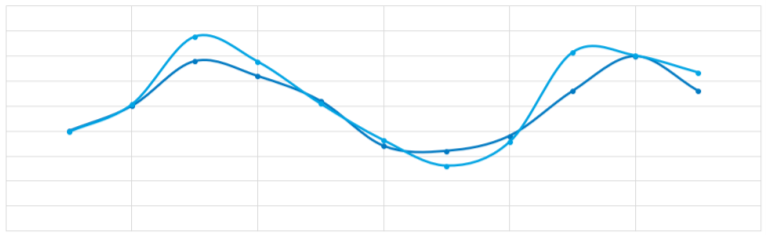

**Достоинства данного подхода:**

- наличие схожей динамики во времени позволяет делать довольно точные прогнозы
для магазинов, принадлежащих к одному кластеру, а также ожидать схожей реакции
на какие-либо изменения внешней среды;
- отсутствует необходимость в признаковом описании объектов.

**Недостатки данного подхода:**

- модель представляет из себя своего рода «черный ящик», а интерпретируемость
кластеров, вероятнее всего, будет слабой;
- не учитываются особенности магазинов и разного рода факторы, которые могут
оказаться полезны при кластеризации;
- c появлением новых исторических данных возникнет необходимость проводить
кластеризацию заново (хотя, с другой стороны, это обеспечивает гибкость данной
модели).


# Альтернативы
---
Рассматривались варианты описания временных рядов фиксированным наборов
статистических характеристик (количество пересечений квартилей и среднего,
стандартное отклонение сглаженного ряда, коэффициенты сплайнов различного
порядка при аппроксимации и пр.), но ни одна из комбинаций таких характеристик
не позволяла получить адекватные результаты при последующей кластеризации. В
связи с этим было решено остановиться на описанной идее.


# Подготовка данных о ежедневных продажах товаров
---

### *START of time-consuming fragment*

In [402]:
demand = pd.DataFrame() # Здесь будет агрегироваться ежедневный спрос на все товары всех магазинов

dates = pd.date_range(sales.date.min(), sales.date.max())
goods = np.unique(sales.goods_type.to_numpy())
shops = np.arange(845)

def date_demand_counter(date):
    date_demand = pd.DataFrame(columns=np.append(['date', 'shop_id'], goods))
    def shop_demand_counter(shop_id):
        return sales[(sales.shop_id==shop_id)&(sales.date==date)].groupby('goods_type').total_items_sold.sum()
    date_demand = pd.Series(shops).apply(shop_demand_counter)
    date_demand['date'] = date
    date_demand['shop_id'] = shops
    return date_demand

demand = pd.Series(dates).apply(date_demand_counter)
    
demand.fillna(0, inplace=True)

demand

0            Бензак  Съедобный хлам   Хлам  Броня и о...
1            Бензак  Съедобный хлам   Хлам  Солярка  ...
2            Бензак  Броня и одежда  Съедобный хлам  ...
3            Бензак  Броня и одежда  Съедобный хлам  ...
4            Бензак  Съедобный хлам   Хлам  Солярка  ...
                             ...                        
725          Бензак  Броня и одежда  Солярка  Съедобн...
726          Бензак  Солярка  Съедобный хлам  Броня и...
727          Бензак  Солярка  Съедобный хлам  Броня и...
728          Бензак  Солярка  Съедобный хлам  Броня и...
729          Бензак  Броня и одежда  Солярка  Съедобн...
Length: 730, dtype: object

In [417]:
demand = pd.concat(demand.to_numpy())
demand.fillna(0, inplace=True)

In [418]:
demand.to_csv('demand.csv')

### *END of time-consuming fragment*

In [3]:
demand = pd.read_csv('demand.csv', index_col=0)

demand.head()

,Бензак,Съедобный хлам,Хлам,Броня и одежда,Солярка,Модификации тачки,Оружие,Патроны,Ядер-Кола,Жидкости для тачки,Медпрепараты и еда,date,shop_id
0,10537.0,6.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2146-01-01,0
1,5510.0,17.0,9.0,2.0,238.0,0.0,0.0,0.0,0.0,0.0,0.0,2146-01-01,1
2,5893.0,115.0,121.0,16.0,629.0,150.0,17.0,671.0,37.0,0.0,0.0,2146-01-01,2
3,14627.0,20.0,63.0,2.0,822.0,0.0,0.0,0.0,0.0,0.0,0.0,2146-01-01,3
4,15525.0,281.0,68.0,13.0,1011.0,15.0,0.0,449.0,146.0,21.0,0.0,2146-01-01,4


In [5]:
# переименовываем товары, чтобы было удобнее работать с ними

old_goods = np.unique(sales.goods_type.to_numpy())
new_goods = ['gas', 'armor', 'liquids', 'medical', 'mods', 
             'weapon', 'ammo', 'diesel', 'foodstuff', 'stuff', 'nucacola']

rule = {old: new for old, new in zip(old_goods, new_goods)}
demand.rename(columns=rule, inplace=True)

goods = np.array(new_goods, dtype=object)

demand

,gas,foodstuff,stuff,armor,diesel,mods,weapon,ammo,nucacola,liquids,medical,date,shop_id
0,10537.0,6.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2146-01-01,0
1,5510.0,17.0,9.0,2.0,238.0,0.0,0.0,0.0,0.0,0.0,0.0,2146-01-01,1
2,5893.0,115.0,121.0,16.0,629.0,150.0,17.0,671.0,37.0,0.0,0.0,2146-01-01,2
3,14627.0,20.0,63.0,2.0,822.0,0.0,0.0,0.0,0.0,0.0,0.0,2146-01-01,3
4,15525.0,281.0,68.0,13.0,1011.0,15.0,0.0,449.0,146.0,21.0,0.0,2146-01-01,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,34200.0,371.0,251.0,52.0,4600.0,45.0,17.0,803.0,569.0,50.0,232.0,2147-12-31,840
841,30260.0,370.0,55.0,46.0,3228.0,48.0,135.0,1155.0,233.0,34.0,92.0,2147-12-31,841
842,38126.0,1237.0,95.0,110.0,5188.0,56.0,146.0,1865.0,1222.0,290.0,727.0,2147-12-31,842
843,32183.0,628.0,60.0,69.0,4034.0,16.0,60.0,1177.0,411.0,91.0,130.0,2147-12-31,843


# Некоторые проблемы и их решения
---

### Проблема 1: выбросы и шум:

Данные оказались довольно шумными, кривые продаж очень сильно колебались, а
выбросы сильно мешали дальнейшим расчетам. Для того, чтобы их отфильтровать
был применен подход аппроксимации ряда сплайнами 2-го порядка.

Сначала ряд аппроксимируется с помощью сплайнов со скользящим окном, а затем
наблюдения, отклоняющиеся от полученной кривой более чем на 1.5 стандартных
отклонения (такое значение было подобрано экспериментальным путем и оказалось
наиболее оптимальным) помечаются как выбросы. После этого значения данных
наблюдений заменяются на пограничные, и ряд можно заново сглаживать или
аппроксимировать, но уже значительно более точно. Пример:

In [4]:
# Создадим класс для обработки временных рядов:
class Timeseries_processing:
    
    def __init__(self, y):
        self.y = y
        self.n = len(y)
        self.y.index = np.arange(self.n)
        self.x = np.arange(self.n)
    
    # В данном методе реализуется аппроксимация ряда полиномом / сплайном (порядка deg)
    def poly_approx(self, index, deg):
        x, y = self.x[index], self.y[index]
        coeffs = np.polyfit(x, y, deg)
        x = x.reshape([-1, 1])
        x_poly = (np.zeros(x.shape) + 1)
        
        for i in range(1, deg + 1):
            x_poly = np.hstack([x**i, x_poly])
        y_approx = coeffs.dot(x_poly.T)
        
        return y_approx, coeffs
        
    # В данном методе реализуется аппроксимация ряда сплайнами (порядка deg) со скользящим окном 
    # (размера window с шагом offset)
    def poly_window_approx(self, window=200, deg=2, offset=5, return_coeffs=False):
        poly_windows = np.zeros([self.n, self.n])
        poly_windows[:] = np.nan
        all_coeffs = np.zeros([1 + ((self.n - window) // offset), deg+1])

        # Для каждого окна аппроксимируем ряд полиномом
        # Записывая результат в отдельную строку с учетом размера окна и шага
        for i in range(0, self.n - window + 1, offset):
            index = np.arange(i, i+window)
            y_window_approx, coeffs = self.poly_approx(index, deg)
            poly_windows[i, i:i+window] = y_window_approx
            all_coeffs[i//offset] = coeffs
        
        # Усредняем по столбцам полиномы, полученные на разных окнах
        # Получаем цельный ряд, длина которого равна исходному
        if return_coeffs:
            return pd.DataFrame(poly_windows).mean().values, all_coeffs
        else:
            return pd.DataFrame(poly_windows).mean().values
    
    # В данном методе реализуется непосредственная фильтрация выбросов
    def outliers_filter(self, coef=1.5):
        original = self.y
        approx = pd.Series(self.poly_window_approx()) 
        original.index = approx.index = np.arange(self.n)

        errors = original - approx # отклонения от аппроксимированного тренда
        outliers = errors[abs(errors) > coef*original.std()].index
        outliers_signs = errors[outliers] / abs(errors[outliers])

        # заменяем выбросы на граничные значения (тренд + 1.5 std)
        original_filtered = original.copy()
        original_filtered[outliers] = approx[outliers] + coef*original.std()*outliers_signs 
        
        return original_filtered

Отобразим пример работы созданного класса

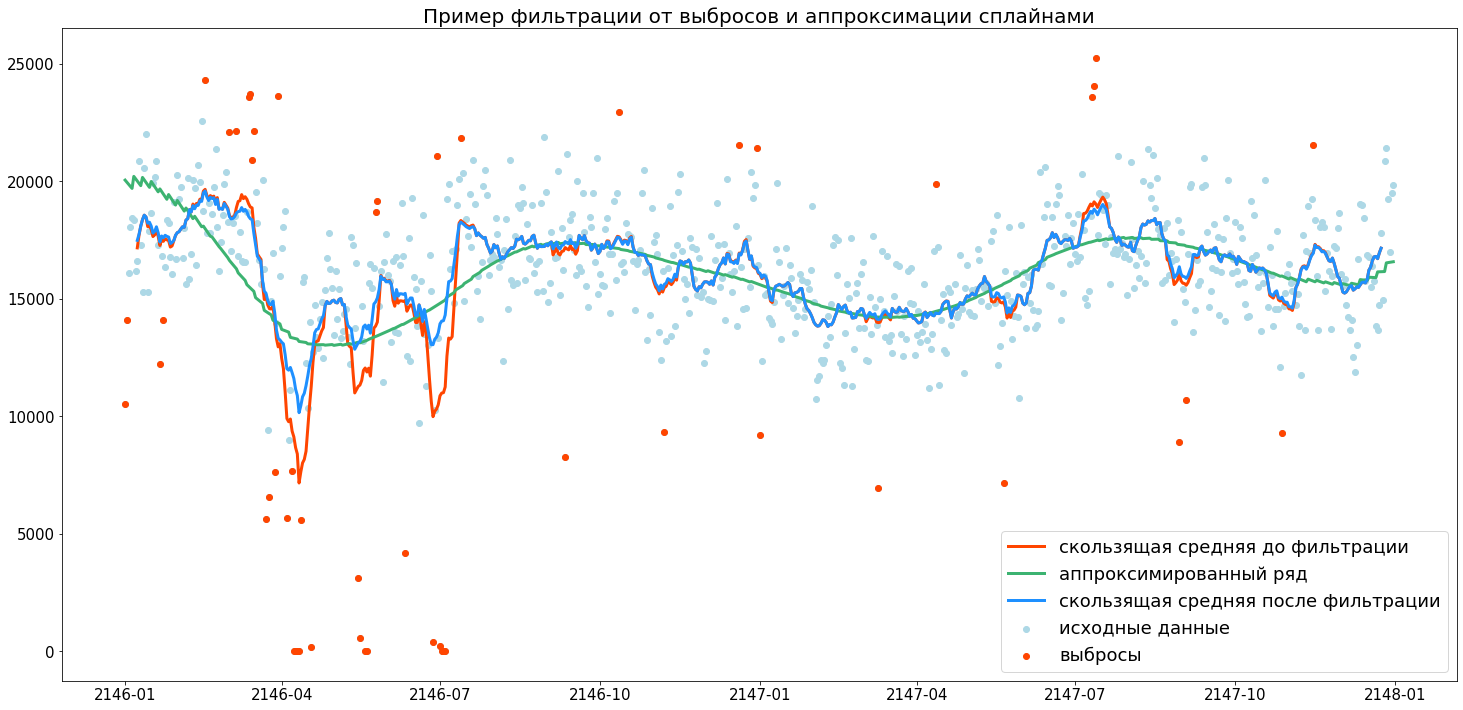

In [412]:
original = demand[demand.shop_id==0]['gas']
dates = pd.date_range(demand.date.min(), demand.date.max())
  
ts_proc = Timeseries_processing(original)

original_approx = ts_proc.poly_window_approx()
errors = original_approx - original

window = 15
filtered_ma = ts_proc.outliers_filter().rolling(window, center=True).mean()
not_filtered_ma = original.rolling(window, center=True).mean()

outliers_to_plot = original.copy()
outliers = original[abs(ts_proc.outliers_filter() - original)>0].index
outliers_to_plot[~errors.index.isin(outliers)] = np.nan

plt.figure(figsize=[25, 12])

plt.scatter(dates, original, color='lightblue')
plt.scatter(dates, outliers_to_plot, color='orangered')
plt.plot(dates, not_filtered_ma, color='orangered', linewidth=3)
plt.plot(dates, original_approx, color='mediumseagreen', linewidth=3)
plt.plot(dates, filtered_ma, color='dodgerblue', linewidth=3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Пример фильтрации от выбросов и аппроксимации сплайнами', fontsize=20)
plt.legend(
    ['скользящая средняя до фильтрации', 'аппроксимированный ряд', 
    'скользящая средняя после фильтрации', 'исходные данные', 'выбросы'],
    loc='lower right', 
    fontsize=18
)

plt.show()

### Проблема 2: разный масштаб и паттерны:

Как было выявлено в ходе анализа, почти все временные ряды для какого-либо
товара описываются схожими паттернами. Это наблюдение и стало отправной точкой
для рассмотрения данной задачи как задачи кластеризации временных рядов
(однако и натолкнуло на мысль о «синтетичности» данных).

1. **Эти паттерны не смещены во времени** – этот факт позволяет использовать именно
евклидово расстояние, а не более продвинутые метрики расстояния.
2. **Эти паттерны растянуты по оси объема продаж** – у разных магазинов разные
объемы продаж и, соответственно, разный размах колебаний временного ряда, тем
не менее паттерны сохраняются.

Было решено сначала аппроксимировать ряды сплайнами (это решает проблему
шума и позволяет улавливать ключевые закономерности), а затем стандартизовать
каждый из них (вычитание среднего и деление на std), что позволяет решить
проблему разного масштаба.

Если подытожить, то **порядок подготовки данных для кластеризации** следующий:
1. Фильтрация временных рядов продаж от выбросов.
2. Аппроксимация сплайнами.
3. Стандартизация.
4. Создание матрицы расстояний между всеми парами объектов.

# Метрика качества кластеризации
---
Среднее расстояние между объектами из одного кластера, деленное на среднее
расстояние до объектов из других кластеров (усредненная еще раз по всем кластерам):

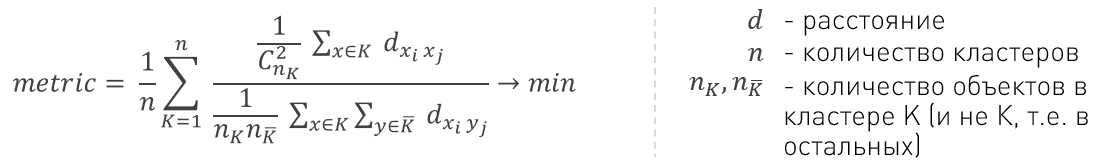

In [ ]:
# Зададим функцию для подсчета метрики:
def metric(cluster_labels, dist_matrix, shops=np.arange(845)):
    n_clusters = cluster_labels.max() + 1 # количество кластеров
    average_dist = 0 # стартовое значение метрики
           
    for clust_num in range(n_clusters): # итерируемся по кластерам
        in_clust = shops[cluster_labels==clust_num] # объекты в кластере
        out_clust = shops[cluster_labels!=clust_num] # объекты вне кластера
        in_clust_new_index = np.arange(len(shops))[cluster_labels==clust_num]
        out_clust_new_index = np.arange(len(shops))[cluster_labels!=clust_num]
        
        # Если в кластере лишь 1 объект, числитель и вклад данного кластера в метрику = 0
        if len(in_clust) == 1:
            continue
            
        # Суммарные расстояния до объектов внутри и вне кластера:
        in_clust_dist = dist_matrix[in_clust_new_index, :][:, in_clust_new_index].sum() / 2
        out_clust_dist = dist_matrix[in_clust_new_index, :][:, out_clust_new_index].sum()
        
        # Усреднение:
        average_in_clust_dist = in_clust_dist * 2 / (len(in_clust)**2 - len(in_clust)) # C из n по 2 (расстояния)
        average_out_clust_dist = out_clust_dist / (len(in_clust) * len(out_clust))
        
        # Частное среднего внутрикластерного расстояния и среднего расстояния до объектов из других кластеров:
        average_in_out_dist = average_in_clust_dist / average_out_clust_dist
        average_dist += average_in_out_dist / n_clusters # прибавляем данное значение к метрике (делим на n тут же)
            
    return average_dist 

# Понятие расстояния
---
Прежде чем ответить на вопрос, как подсчитать расстояние между двумя кластерами, необходимо выяснить, все ли магазины продают одни и те же наборы товаров. Ведь если какой-то магазин продавал товары А и B, а другой - товары B и C, то как подсчитать расстояния между ними?


In [38]:
# здесь будем аггрегировать, какой магазин какие товары продает (845 магазинов х 11 товаров)
# 1 - продает, 0 - не продает
combs_df = pd.DataFrame(np.zeros([845, 11]), columns=goods, dtype=int)

for shop_id in np.arange(845):
    for good_type in goods:
        current_ts = demand.loc[demand.shop_id==shop_id, good_type]
        
        # если хотя бы 3/4 значений <= 0, значит продаж данного товара в данном магазине было или мало
        # или они нерегулярные - такой ряд будет выбросом
        # это негативно скажется на дальнейших расчетах
        # поэтому проще этот ряд не рассматривать вообще (считая, что данный магазин не продает такой товар)
        # здесь инверсия данного правила:
        if (current_ts<=0).sum() < 0.25*len(current_ts):
            combs_df.loc[shop_id, good_type] = 1

combs_df.head()

,gas,armor,liquids,medical,mods,weapon,ammo,diesel,foodstuff,stuff,nucacola
0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,1,0,0
2,1,1,0,0,0,0,1,1,1,1,1
3,1,0,0,0,0,0,0,1,1,1,0
4,1,1,0,1,0,0,1,1,1,1,1


In [39]:
# Сколько магазинов продает каждый из товаров:
combs_df.sum()

gas          845
armor        646
liquids      195
medical      550
mods         362
weapon       104
ammo         687
diesel       802
foodstuff    755
stuff        738
nucacola     644
dtype: int64

In [51]:
combs = []

for i in range(845):
    comb = combs_df.iloc[i][combs_df.iloc[i]==1].index
    combs.append(list(comb))

combs = np.array(combs)
unique_combs = np.array(sorted(list(np.unique(combs)), key=lambda l: len(l), reverse=True))

unique_combs

# уникальные комбинации товаров
# 31 комбинация

array([list(['gas', 'armor', 'liquids', 'medical', 'mods', 'weapon', 'ammo', 'diesel', 'foodstuff', 'stuff', 'nucacola']),
       list(['gas', 'armor', 'liquids', 'medical', 'mods', 'ammo', 'diesel', 'foodstuff', 'stuff', 'nucacola']),
       list(['gas', 'armor', 'medical', 'mods', 'weapon', 'ammo', 'diesel', 'foodstuff', 'stuff', 'nucacola']),
       list(['gas', 'armor', 'liquids', 'medical', 'ammo', 'diesel', 'foodstuff', 'stuff', 'nucacola']),
       list(['gas', 'armor', 'liquids', 'medical', 'mods', 'ammo', 'foodstuff', 'stuff', 'nucacola']),
       list(['gas', 'armor', 'medical', 'mods', 'ammo', 'diesel', 'foodstuff', 'stuff', 'nucacola']),
       list(['gas', 'armor', 'medical', 'ammo', 'diesel', 'foodstuff', 'stuff', 'nucacola']),
       list(['gas', 'armor', 'ammo', 'diesel', 'foodstuff', 'stuff', 'nucacola']),
       list(['gas', 'armor', 'liquids', 'ammo', 'diesel', 'foodstuff', 'stuff']),
       list(['gas', 'armor', 'medical', 'ammo', 'foodstuff', 'stuff', 'nucacola']),

---
Как было выявлено в ходе анализа, далеко не все магазины продают весь набор из
11 товаров (по крайней мере если исходить из данных о продаж). Некоторые из них и
вовсе за последние 2 года не продавали ничего кроме бензака. Следовательно,
встает вопрос: как измерить расстояние между объектами, описывающимися
разными наборами временных рядов? Одно радует – **ситуации с непересекающимися
наборами нет** (как минимум бензак продают все магазины). Кроме того, какую
метрику расстояния ввести?

В качестве метрики было выбрано обычное **евклидово расстояние** (то есть корень из
суммы квадратов расстояний между значениями продаж двух объектов в момент
времени t) – она полностью удовлетворяет нашим требованиям.

В свою очередь, чтобы измерять расстояние между объектами с разными наборами
товаров, было решено брать **среднее по всем пересекающимся рядам расстояние**.
Например, каждый из двух магазинов продает 5 различных товаров, из которых
общих только 2, в таком случае расстояние между ними – сумма расстояний между
этими двумя общими рядами, деленная на 2.

In [417]:
# Зададим функцию для получения матрицы расстояний:
def get_dist_matrix(data, shops=np.arange(845), goods_labels=goods):
    dist_matrix = np.zeros([len(shops), len(shops)]) # матрица суммарных расстояний
    intersections_matrix = np.zeros([len(shops), len(shops)]) # матрица с количеством пересекающихся наборов (для усреднения)
    
    for shop_id_1 in shops:
        if shop_id_1 != len(shops) - 1:
            for shop_id_2 in shops[shop_id_1+1:]:
                intersection = len(set(combs[shop_id_1])&set(combs[shop_id_2])) # подсчет количества пересекающихся наборов
                intersections_matrix[shop_id_1, shop_id_2] += intersection # добавление в матрицу количества пересечений
    
    # Приводим матрицу к симметричному виду и заполняем главную диагональ единицами (во избежание деления на 0)
    intersections_matrix = (intersections_matrix + intersections_matrix.T) + np.eye(len(shops))
    
    for good_label in goods_labels: # итерируемся по всем товарам
        for i, shop_id in enumerate(shops):
            if i != len(shops) - 1:
                if combs_df.loc[i, good_label] == 1: # продает ли текущий магазин данный товар
                    
                    # Продажи данного товара для текущего магазина и для остальных
                    current = data.loc[data.shop_id==shop_id, good_label].to_numpy() 
                    rest = data.loc[data.shop_id>shop_id, good_label].to_numpy()
                    rest = rest.reshape(len(current), len(rest)//len(current)).T
                    
                    dist_vec = ((rest - current)**2).sum(axis=1)**0.5 # евклидово расстояние
                    dist_matrix[i, i+1:] += dist_vec * combs_df.loc[i+1:, good_label].to_numpy()
                    # домножение на данный вектор необходимо, чтобы не учитывать расстояния по данному товару
                    # до тех магазинов, которые им не торгуют
        
    # Приводим матрицу к симметричному виду и усредняем путем поэлементного деления на матрицу количества пересечений    
    return (dist_matrix + dist_matrix.T) / intersections_matrix

# Подготовка данных для кластеризации
---

Напомним, что **порядок подготовки данных для кластеризации** следующий:
1. Фильтрация временных рядов продаж от выбросов.
2. Аппроксимация сплайнами.
3. Стандартизация.
4. Создание матрицы расстояний между всеми парами объектов.

### *START of time-consuming fragment*

In [60]:
goods_labels = goods
shops = np.arange(845)
demand_approx = demand.copy()

for good_label in goods_labels: # трансформируем все данные в аппроксимированные 
    for shop_id in shops:
        ts_proc = Timeseries_processing(demand_approx[demand_approx.shop_id==shop_id][good_label])
        ts_filtered = ts_proc.outliers_filter()
        ts_proc = Timeseries_processing(ts_filtered)
        ts_approx = ts_proc.poly_window_approx(window=250, offset=1)
        scaler = StandardScaler() # стандартизуем с центрированием
        ts_approx = scaler.fit_transform(ts_approx.reshape([-1, 1]))
        demand_approx.loc[demand_approx.shop_id==shop_id, good_label] = ts_approx
        
demand_approx.head()

,gas,foodstuff,stuff,armor,diesel,mods,weapon,ammo,nucacola,liquids,medical,date,shop_id
0,3.029697,3.872512,4.150413,3.819583,0.000000,0.000000,0.000000,0.000000,0.000000,4.224704,0.000000,2146-01-01,0
1,-2.337576,-1.791526,0.594549,-0.636440,-2.126679,0.000000,0.000000,0.000000,0.000000,0.627581,0.000000,2146-01-01,1
2,-1.626838,-2.235213,1.500084,-1.530541,0.816287,1.000305,-0.409971,-1.760862,-1.077308,-0.891818,-0.832923,2146-01-01,2
3,-1.647278,-1.980784,-1.071582,-1.653816,-1.540641,0.170385,0.013304,0.000000,-0.379330,-0.735528,0.000000,2146-01-01,3
4,0.487234,-2.346257,1.755328,-0.781652,-1.013746,-0.476221,-1.703308,-2.073639,-2.119881,0.035314,-4.217889,2146-01-01,4


In [61]:
demand_approx.to_csv('demand_approx.csv')

### *END of time-consuming fragment*

In [62]:
demand_approx = pd.read_csv('demand_approx.csv', index_col=0)

In [ ]:
# Создаем матрицу расстояний
dist_matrix = get_dist_matrix(demand_approx)

# Кластериазция
---
Для решения задачи кластеризации временных рядов был выбран алгоритм
**агломеративной иерархической кластеризации**. Основные причины:
1. Можно задать свою матрицу расстояний.
2. Простота и скорость работы алгоритма в сочетании с его эффективностью.

Более продвинутые алгоритмы, например, основанные на плотности (DBSCAN,
OPTICS) или на графах, предназначены для другого класса задач, и в данном случае
результаты получились бы неадекватными.

Необходимо также задать меру расстояния между двумя кластерами для реализации
агломеративной кластеризации. На эту роль был выбран **метод средней связи (average linkage)**, так
как он хорошо согласуется с выбранной метрикой качества, а также интуитивно
кажется наиболее логичным в рассматриваемой ситуации.

**Найдем по нашей метрике оптимальное количество кластеров**:

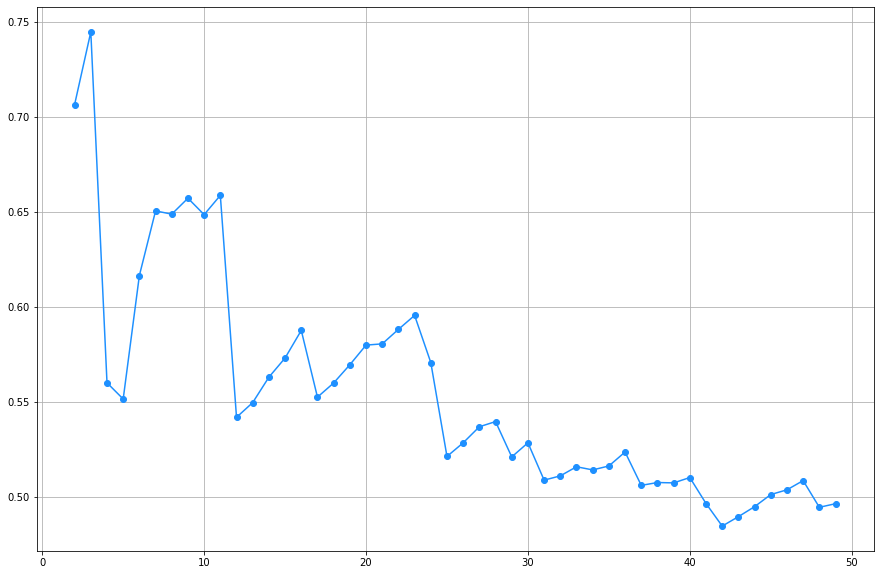

In [493]:
metrics_n = []

for i in range(2, 50):
    clusterisation = AgglomerativeClustering(linkage='average', n_clusters=i, affinity='precomputed').fit(dist_matrix)
    labels_clust = clusterisation.labels_
    metric_i = metric(labels_clust, dist_matrix)
    metrics_n.append(metric_i)
    
plt.figure(figsize=[15, 10])
plt.plot(np.arange(2, 50), metrics_n, color='dodgerblue', marker='o')
plt.grid(True)

Очевидно, что при увеличении количества кластеров, значение метрики стремится к 0, т.к. к 0 стремится внутрикластерное расстояние. Однако, цель - найти баланс между количеством кластеров (их должно быть не слишком много) и значением метрики. 

В нашем случае хорошо подходит значение 4, однако в данном случае кластеры все же получаются слишком разнородными (в 1 кластер попадает большинство объектов, а в другие - наиболее на них непохожие). Было решено остановиться на другом локальном минимуме - 12 кластеров. В таком случае картина получается более адекватной, хоть и по-прежнему далекой от идеала

In [577]:
clusterisation = AgglomerativeClustering(linkage='average', n_clusters=12, affinity='precomputed').fit(dist_matrix)
labels_clust = clusterisation.labels_

Посмотрим на
некоторые примеры временных рядов продаж магазинов, оказавшихся в одном
кластере (синим цветом обозначено среднее, ряды сглажены и стандартизованы,
товар на графиках - бензак):

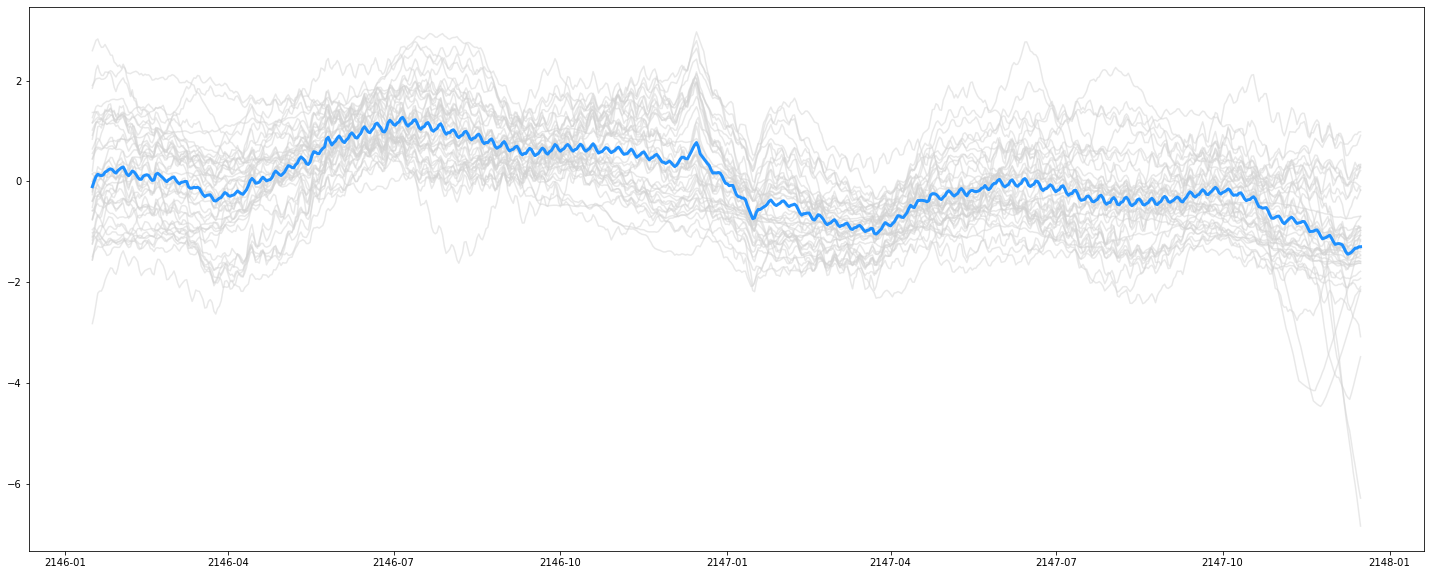

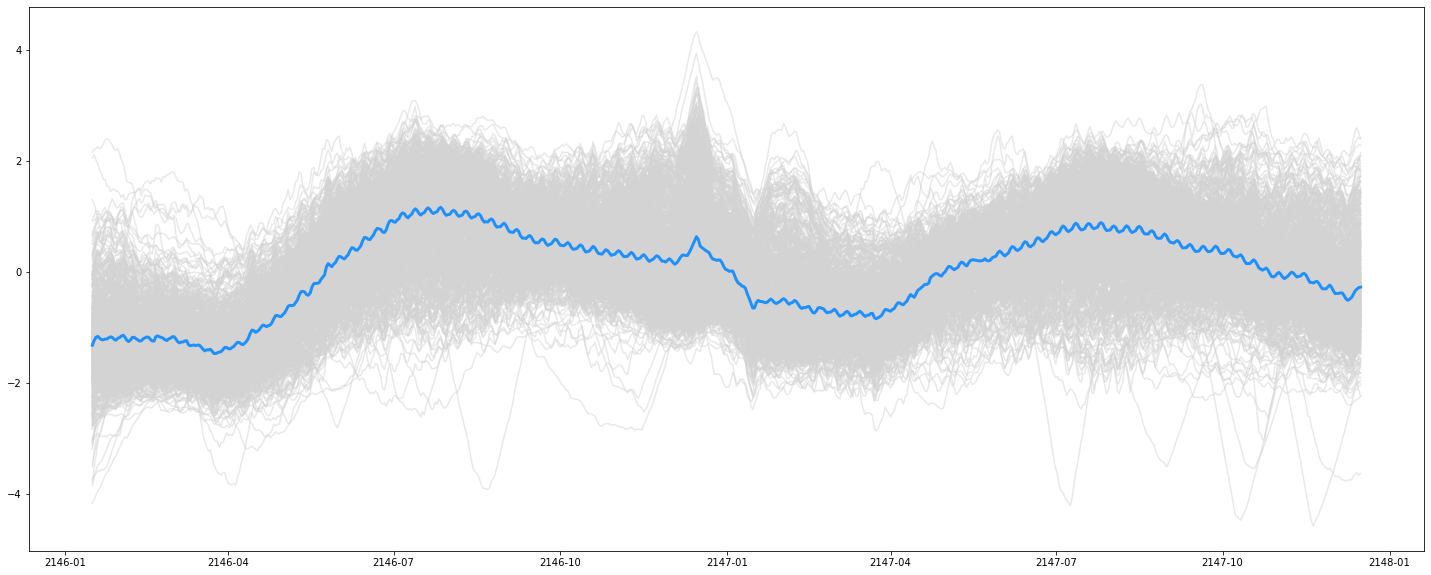

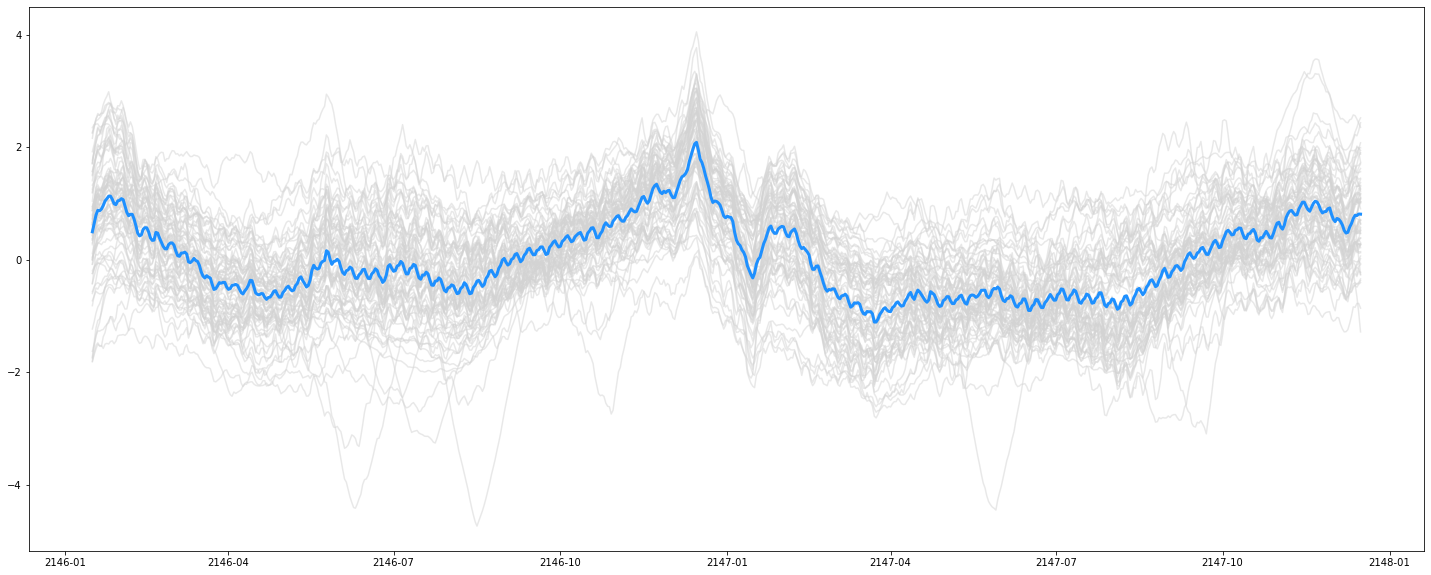

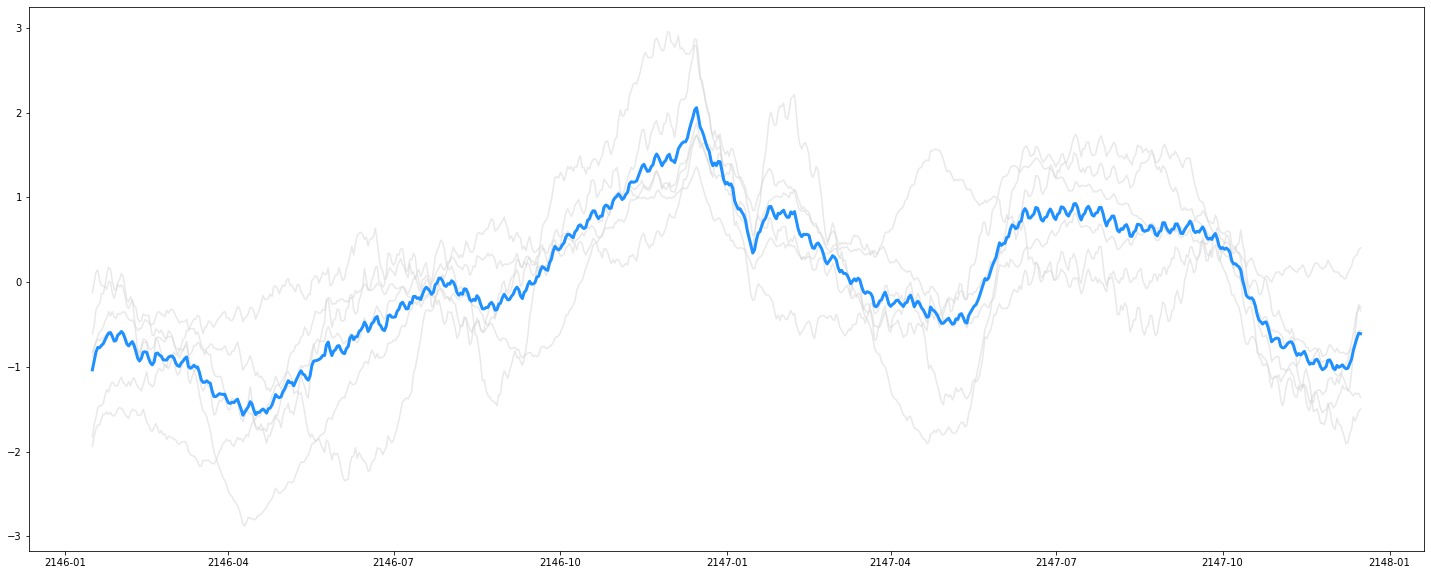

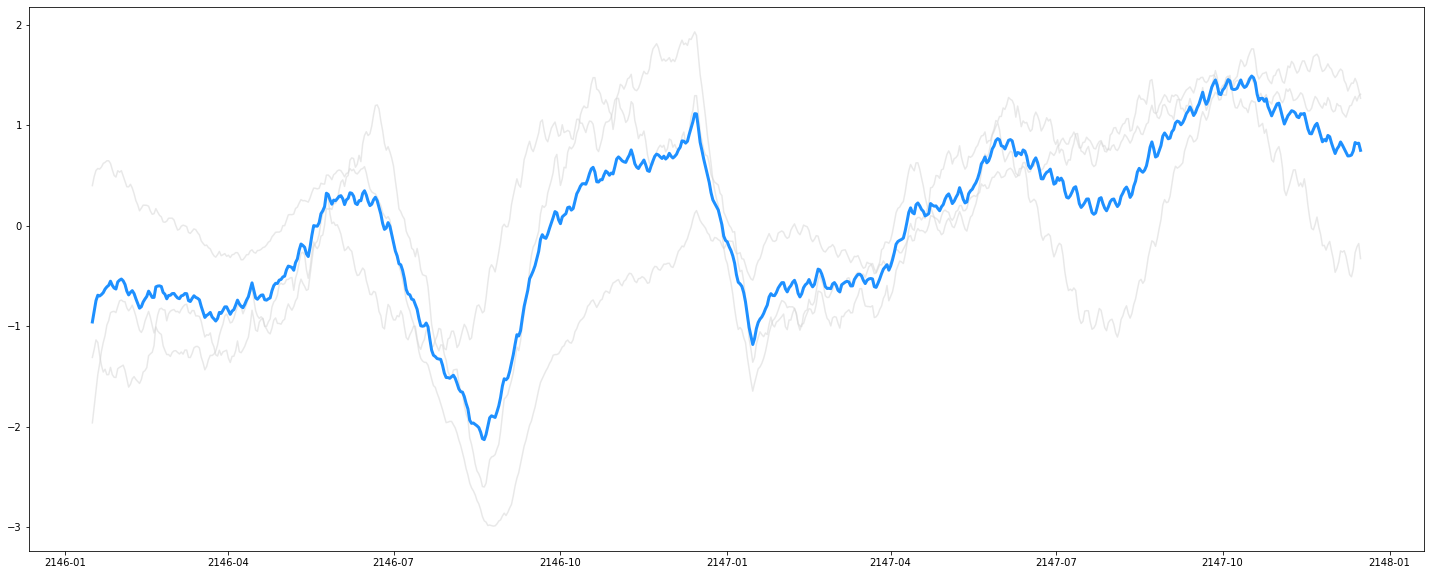

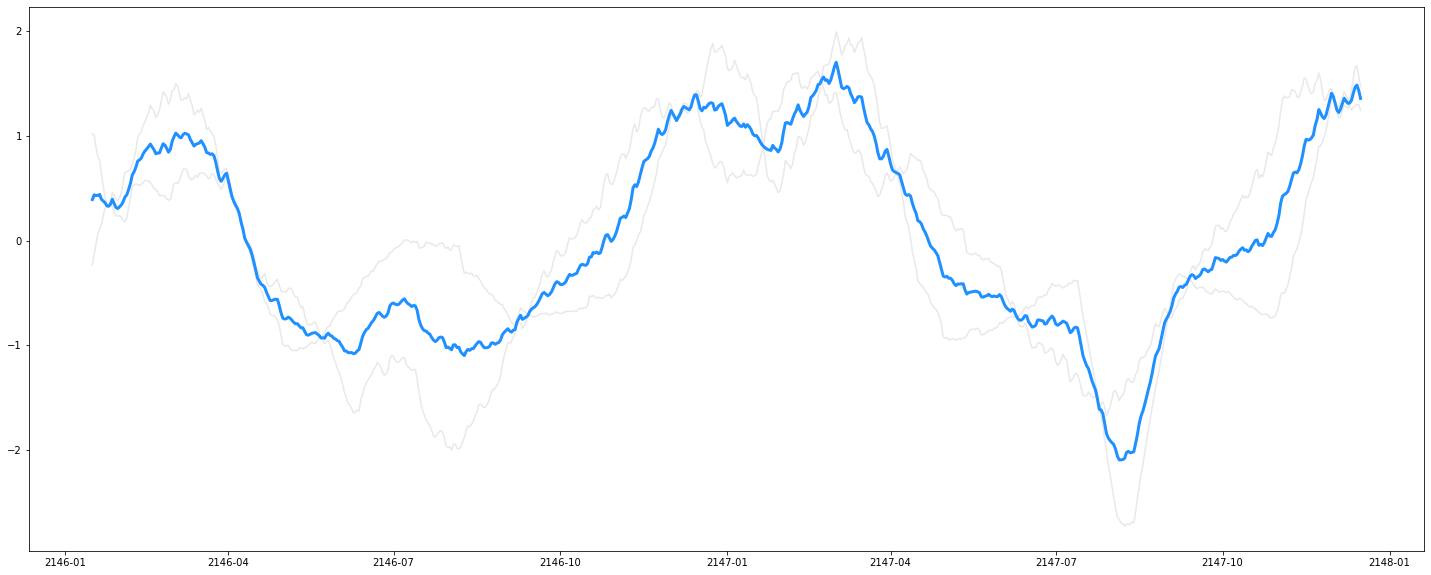

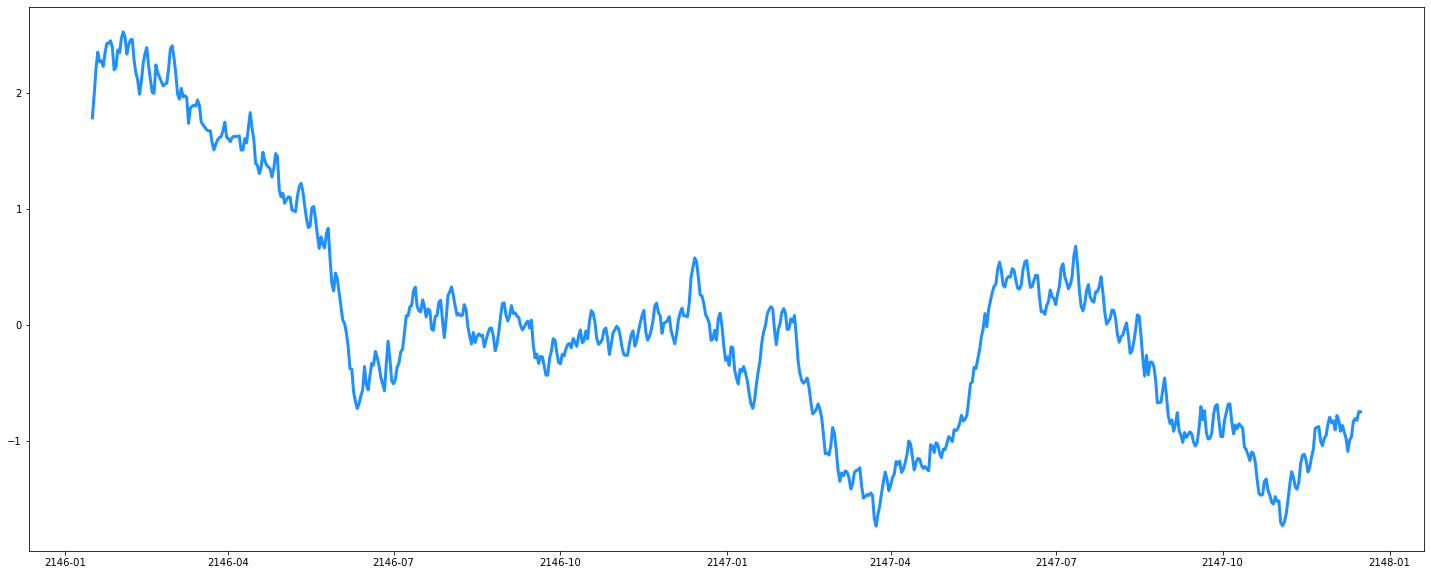

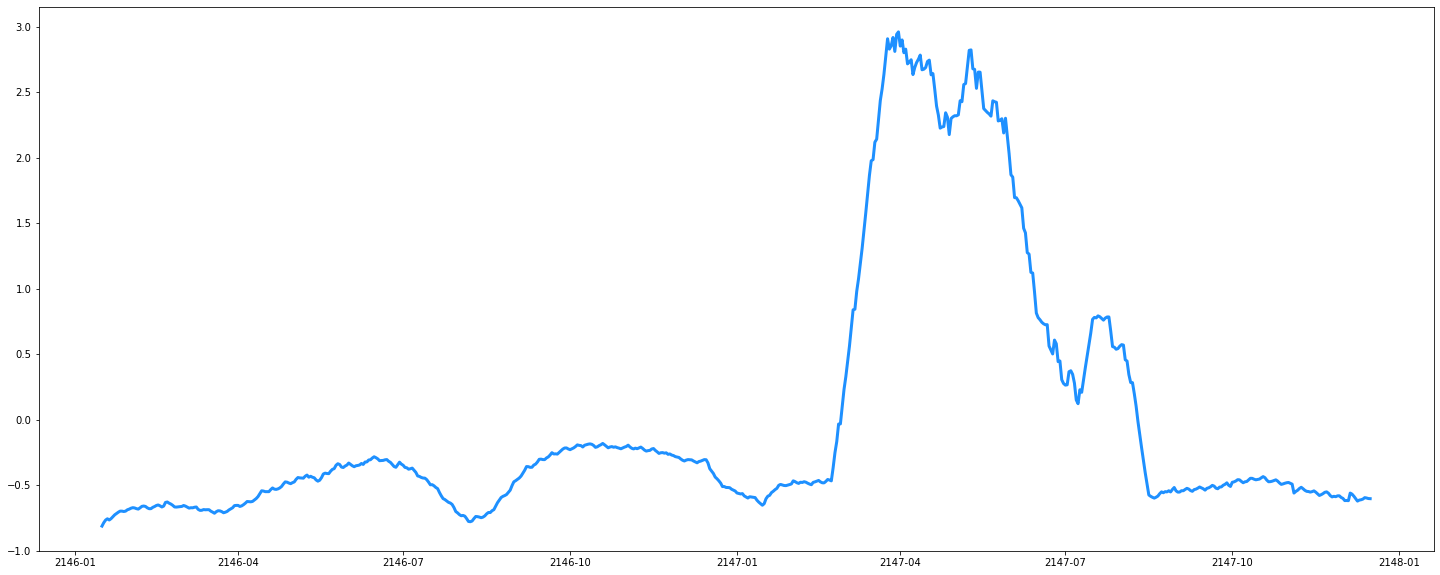

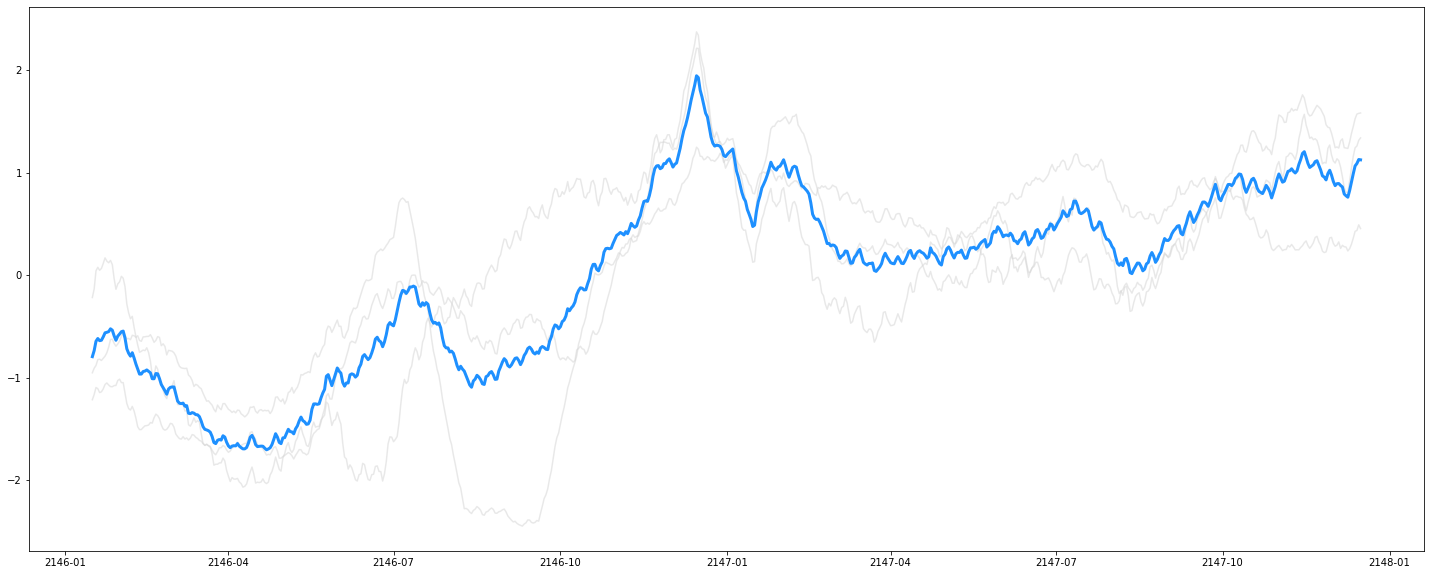

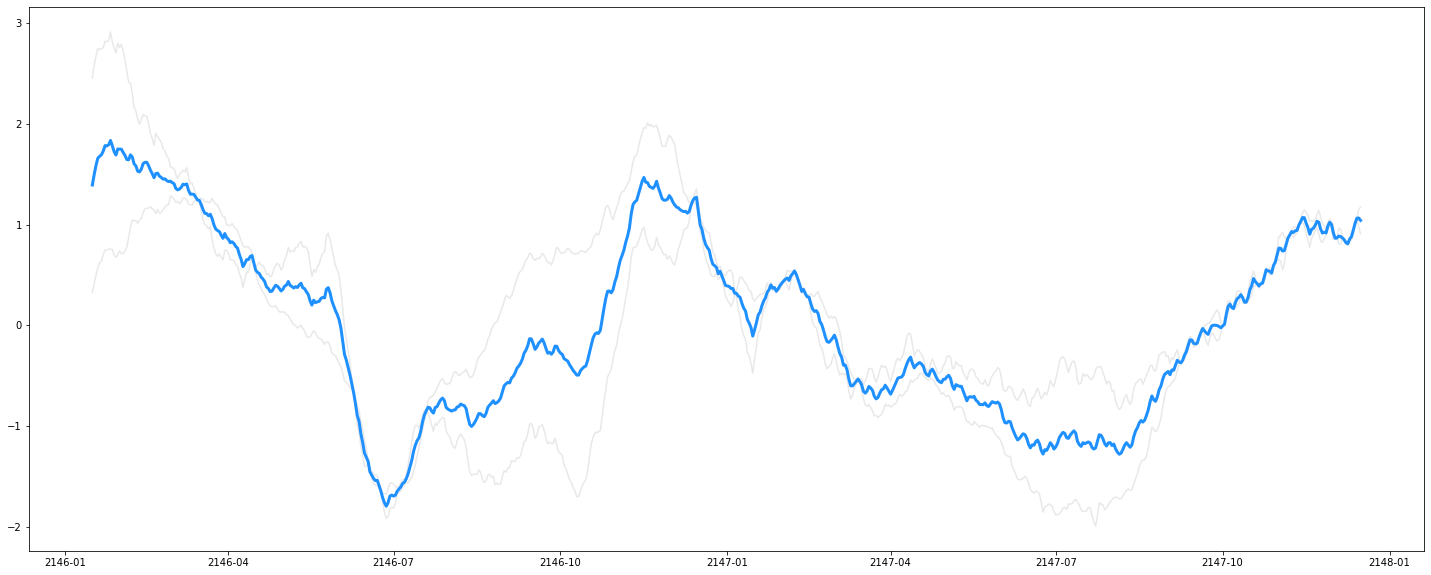

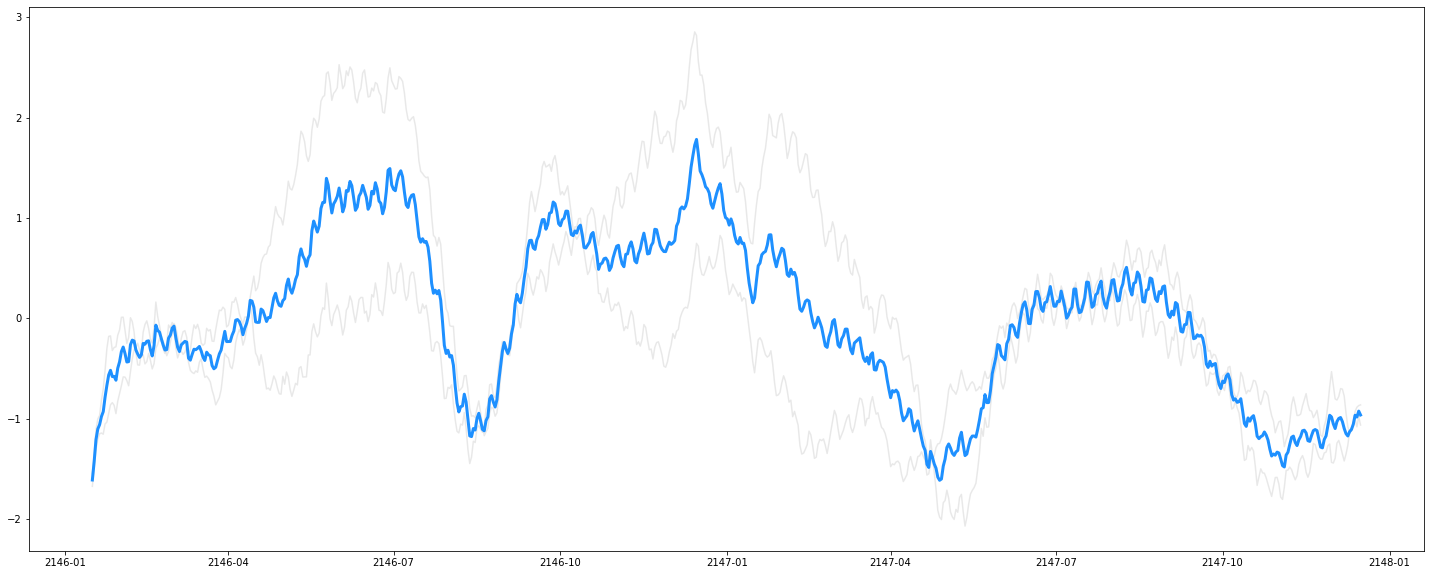

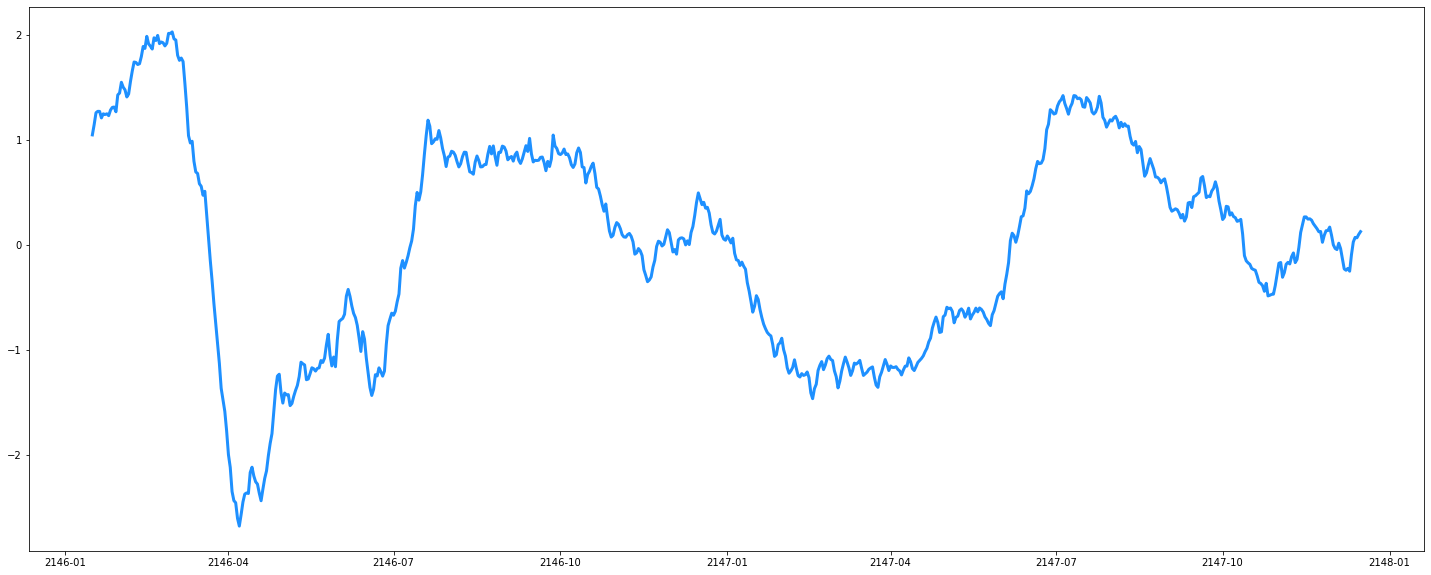

In [585]:
window = 31

for label in np.arange(12):
    mean_ = np.zeros(730)
    plt.figure(figsize=[25, 10])
    for i in np.arange(845)[labels_clust==label]:
        ts_proc = Timeseries_processing(demand[demand.shop_id==i]['gas'])
        ma = ts_proc.outliers_filter().rolling(window, center=True).mean()
        scaler = StandardScaler()
        ma = scaler.fit_transform(ma.to_numpy().reshape([-1, 1]))
        ma = ma.reshape([-1, ])
        mean_ += ma
        plt.plot(dates, ma, alpha=0.5, color='lightgray')
    mean_ /= len(shops[labels_clust==label])
    plt.plot(dates, mean_, linewidth=3, color='dodgerblue')
    plt.show()

In [ ]:
# Экспортируем полученные метки кластеров

shops_clusters = pd.Series(data=labels_clust, dtype=int)    
shops_clusters.to_csv('clusters.tsv', sep = '\t')

В результате кластеризации было получено 12 кластеров. К сожалению, так вышло,
что большинство объектов попало в один кластер, а некоторые кластеры наоборот
оказались слишком маленькими. Однако, даже такая кластеризация оказывается
более эффективной, чем та, что была раньше.

Как уже было сказано, единственный способ, которым пользовалась компания в
прошлом – это разбитие по географическому признаку, то есть по городам. Сравним
полученное разбиение с разбиением по городам на основе введенной метрики
расстояния:

In [564]:
old_clusters = shops.city.copy().to_numpy()
new_rule = {label: np.arange(15)[i] for i, label in enumerate(shops.city.value_counts().index)}

for label in shops.city.value_counts().index:
    old_clusters[old_clusters==label] = new_rule[label]
    
old_clusters[old_clusters==None] = 15

**Значение метрики для старого разделения (на 16 кластеров по географическому признаку):**

In [570]:
metric(old_clusters, dist_matrix)

0.9996766065287541

**Значение метрики для полученного разделения (на 12 кластеров):**

In [581]:
metric(labels_clust, dist_matrix)

0.5417793609219567

Таким образом, удалось улучшить значение метрики **почти в 2 раза**

# Комментарии и критика полученного решения
---
Полученное решение является далеко не самым качественным, однако автор уверен,
что сама идея довольно хорошая. Определенно, модель необходимо дорабатывать и
корректировать. Например, если была бы известна модель, по которой
прогнозируется спрос в компании на данный момент, можно было бы внести ряд
корректировок в полученное разбиение.

Кроме того, данные о продажах, вероятнее всего, являются «синтетическими», в
связи с чем результаты получились довольно неадекватные, так как временные ряды
очень похожи между собой (практически все), если их стандартизовать и
аппроксимировать. На реальных данных, вероятнее всего, такой проблемы не
возникло бы и разбиение получилось бы более адекватным. Однако, это лишь предположение.

Ну и в конце концов, на доработку модели банально не хватило времени, некоторые
правки вносились буквально в последний момент, а некоторые гипотезы так и не
удалось проверить.